In [271]:
# Installing Libraries not present
#!pip install textract

## **Resume Screening**

In an organization, hiring resources is an important part for the growth of an organization. The career portal will usually list out different job openings. Individual candidates and third party consultancy will be uploading numerous resumes for each job profile.

However, for the hiring comititee, going through each of the resume and selecting the candidate for interview is a tedious manual process.

Till date, hiring team has been assigning matching percentage to the candidate's resume according to the match to the exact job description (JD). However, going through each resume is still a time taking process.

In this project, we introduce a ML model, which can extract text from resume and will predict the match percentage with respect to the JD.

In [272]:
import PyPDF2
import pdfplumber
import textract
import re
import string
import pandas as pd
import numpy as np
import re
from sklearn.metrics  import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_validate, cross_val_score
import seaborn as sns
from nltk.corpus import stopwords

####Connecting to Google Drive to access the datasets####

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


####Reading the contents of the training dataset and storing in pandas dataframe####

In [274]:
df = pd.read_csv('/content/drive/MyDrive/My Projects/Resume_Screening/dataset/train.csv')
df.head()

,CandidateID,Match Percentage
0,candidate_011,13.60
1,candidate_113,36.63
2,candidate_123,54.93
3,candidate_012,41.46
4,candidate_002,48.91


In [275]:
# Shape of dataframe
df.shape

(90, 2)

In [276]:
# Number of unique candidates Ids
df.CandidateID.nunique()

90

####Analyzing the distribution of the label - Match Percentage####

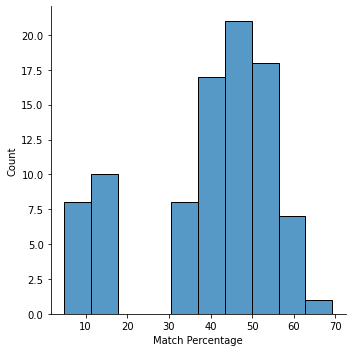

In [277]:
# Analyzing the Match Percentage
sns.displot(data=df['Match Percentage'])

####Function to Extract Text from PDF for all train candidates####
Following Clean up activity on the extracted text:-
1. Removal of numbers
2. Removal of extra white space
3. Removal of urls
4. Removal of hashtags, mentions, RT, cc
5. Removal of punctuations
6. Converting all characters to lower case

In [278]:
# Function to extract text from resume

def extract_resume_text(cand_id=None):
    if cand_id is None:
      pdfname = extract_path
    else:
      pdfname = extract_path + cand_id + '.pdf'

    with pdfplumber.open(pdfname) as pdf:
        first_page = pdf.pages[0]
        text = first_page.extract_text()    

    text = text.lower()
    text = re.sub(r'\d+','',text)
    text = re.sub(r'\n',' ',text)
    text = re.sub('http\S+\s*', ' ', text)  # remove URLs
    text = re.sub('RT|cc', ' ', text)  # remove RT and cc
    text = re.sub('#\S+', '', text)  # remove hashtags
    text = re.sub('@\S+', '  ', text)  # remove mentions
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', text)  # remove punctuations
    text = re.sub(r'[^\x00-\x7f]',r' ', text) 
    text = re.sub('\s+', ' ', text)  # remove extra whitespace

    return text

####Removal of Stop words from the extracted text####

In [279]:
#import nltk
#nltk.download('stopwords')
extract_path = r'/content/drive/MyDrive/My Projects/Resume_Screening/dataset/Job description.pdf'
job_profile_text = extract_resume_text()
stop_words = set(stopwords.words('english'))
job_related_text = [word for word in job_profile_text.split() if word not in stop_words]

####Function to extract only relevant words matching to the JD####

In [282]:
def extract_profile_matching_text(cleaned_text):
  profile_matching_text = ''
  for word in cleaned_text.split():
    if word in job_related_text:
      profile_matching_text = profile_matching_text + ' ' + word
  return profile_matching_text

####Extracting texts from all resumes####

In [283]:
extract_path = r'/content/drive/MyDrive/My Projects/Resume_Screening/dataset/trainResumes/'
df['extracted_text'] = df['CandidateID'].apply(extract_resume_text)
df['profile_matching_text'] = df['extracted_text'].apply(extract_profile_matching_text)
df['profile_matching_text_length'] = df['profile_matching_text'].apply(lambda x:len(x.split()))

In [284]:
df.head()

,CandidateID,Match Percentage,extracted_text,profile_matching_text,profile_matching_text_length
0,candidate_011,13.60,l i a m a n d r e w s fresher executive work e...,work experience responsible making engineerin...,17
1,candidate_113,36.63,ellie mackey fresher intern executive profile ...,work experience master degree learn machine l...,28
2,candidate_123,54.93,felix winston fresher about fresher having kno...,knowledge machine learning natural language p...,31
3,candidate_012,41.46,jimmy gartner da t a m a n a g e r professiona...,work data data data big data analytics analyt...,21
4,candidate_002,48.91,mason quadrado associate analyst about certifi...,data degree engineering experience data machi...,27


In [285]:
df['profile_matching_text'][2]

' knowledge machine learning natural language processing learn work different data data machine learning data data science natural language processing data data analysis work experience data ml data neural networks data science'

In [286]:
requiredTarget = df['Match Percentage'].values

####Function to perform hot encoding on all the relevant extracted texts (Not used in training model)####

In [287]:
def hot_encoded_profile_matching_text(df):
  embedding_df = pd.DataFrame(np.zeros([df.shape[0],len(job_related_text)]),columns=job_related_text)
  for idx in df.index:
    for word in df.loc[idx,'profile_matching_text'].split():
      embedding_df.loc[idx,word]=1
  return embedding_df

####Creating a TFIDF vectorizer model and training it with the extracted train resume data####

In [288]:
# Using TFIDF for word embedding
from sklearn.feature_extraction.text import TfidfVectorizer
requiredText = df['extracted_text'].values
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    stop_words='english',
    max_features=19)
word_vectorizer.fit(requiredText)
WordFeatures_tfidf = word_vectorizer.transform(requiredText)

In [289]:
train_x = WordFeatures_tfidf.toarray()
train_y = np.log(requiredTarget) # Taking log of match percentage as regression model can predict -ve result
train_x.shape

(90, 19)

####Train Linear Regression Model####

In [291]:
# Training Linear Regression Model for prediction of matching percentage
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
model = LinearRegression()

error = cross_validate(model, train_x, train_y, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

# Train Error on train dataset
train_error = max(0, abs(np.mean(error['train_score'])))
print('Linear Regression Train Error : ', train_error)
test_error = max(0, abs(np.mean(error['test_score'])))
print('Linear Regression Test Error : ', test_error)

Linear Regression Train Error :  0.1205782476259925
Linear Regression Test Error :  0.221502397305608


####Train Ridge Regression Model####

In [292]:
# Training Ridge Regression Model for prediction of matching percentage
from sklearn.linear_model import Ridge
ridge_model = Ridge()

# predict the target on the train dataset
error = cross_validate(ridge_model, train_x, train_y, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

# Train Error on train dataset
train_error = max(0, abs(np.mean(error['train_score'])))
print('Ridge Regression Train Error : ', train_error)
test_error = max(0, abs(np.mean(error['test_score'])))
print('Ridge Regression Test Error : ', test_error)

Ridge Regression Train Error :  0.17226463879536644
Ridge Regression Test Error :  0.23538048843760612


####Train Lasso Regression Model####

In [293]:
# Training Lasso Regression Model for prediction of matching percentage
from sklearn.linear_model import Lasso
lasso_model = Lasso()

# predict the target on the train dataset
error = cross_validate(lasso_model, train_x, train_y, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

# Train Error on train dataset
train_error = max(0, abs(np.mean(error['train_score'])))
print('Lasso Regression Train Error : ', train_error)
test_error = max(0, abs(np.mean(error['test_score'])))
print('Lasso Regression Test Error : ', test_error)

Lasso Regression Train Error :  0.40913985758732474
Lasso Regression Test Error :  0.4180960645634017


####Train Random Forest Regression Model####

In [294]:
# Training Random Forest Regression Model for prediction of matching percentage
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
rf_model = RandomForestRegressor(n_estimators=10, random_state=2)

# predict the target on the train dataset
error = cross_validate(rf_model,train_x,train_y,cv=5,scoring='neg_mean_squared_error', return_train_score=True)

# Train Error on train dataset
train_error = max(0, abs(np.mean(error['train_score'])))
print('Random Forest Regression Train Error : ', train_error)
test_error = max(0, abs(np.mean(error['test_score'])))
print('Random Forest Regression Test Error : ', test_error)

Random Forest Regression Train Error :  0.0567053317318811
Random Forest Regression Test Error :  0.27623565427237584


####Train Ada Boost Regression Model####

In [295]:
# Training Ada Boost Regression Model for prediction of matching percentage
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_log_error
ada_model = AdaBoostRegressor(n_estimators=10, random_state=2)

# predict the target on the train dataset
error = cross_validate(ada_model,train_x,train_y,cv=5,scoring='neg_mean_squared_error', return_train_score=True)

# Train Error on train dataset
train_error = max(0, abs(np.mean(error['train_score'])))
print('Ada Boost Regression Train Error : ', train_error)
test_error = max(0, abs(np.mean(error['test_score'])))
print('Ada Boost Regression Test Error : ', test_error)

Ada Boost Regression Train Error :  0.028572511083718923
Ada Boost Regression Test Error :  0.3438287525091277


####Initializing Final Model based on model training performances####

In [296]:
final_model = ridge_model
final_model.fit(train_x,train_y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

###Predict Test Data###

In [297]:
# Reading the test file with candidate Ids
test_data_original = pd.read_csv('/content/drive/MyDrive/My Projects/Resume_Screening/dataset/test.csv')
test_data = test_data_original.copy()
test_data.head()

,CandidateID
0,candidate_014
1,candidate_098
2,candidate_075
3,candidate_016
4,candidate_131


In [298]:
# Extracting resume text from test data resume
extract_path = r'/content/drive/MyDrive/My Projects/Resume_Screening/dataset/testResumes/'
test_data['extracted_text'] = test_data['CandidateID'].apply(extract_resume_text)
requiredText = test_data['extracted_text'].values
test_x = word_vectorizer.transform(requiredText).toarray()
test_x.shape

(60, 19)

In [299]:
# predict the target on the test dataset
predict_test = np.exp(final_model.predict(test_x))

In [300]:
submission_df = test_data_original.copy()
submission_df['Match Percentage'] = predict_test
submission_df.head()

,CandidateID,Match Percentage
0,candidate_014,25.435495
1,candidate_098,19.328429
2,candidate_075,29.613314
3,candidate_016,30.310077
4,candidate_131,26.924460


In [301]:
import time
secondsSinceEpoch = time.time()
timeObj = time.localtime(secondsSinceEpoch)
timestamp = f'{timeObj.tm_mday}_{timeObj.tm_mon}_{timeObj.tm_year}_{timeObj.tm_hour}{timeObj.tm_min}'
final_submission_name = 'final_submissions_' + timestamp + '.csv'
final_submission_name

'final_submissions_7_9_2021_1854.csv'

In [302]:
submission_df.to_csv('/content/drive/MyDrive/My Projects/Resume_Screening/'+final_submission_name,index=False)